<a href="https://colab.research.google.com/github/haris-lutafullah/Research-Work/blob/main/Traffic_Prediction_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#<p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 1px; color:#207d06; font-size:100%; text-align:left;padding: 0px; border-bottom: 3px solid #207d06;">**Importing Library Files**</p>

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input, LSTM, Dropout, Dense, Add, LayerNormalization, Conv1D, GlobalAveragePooling1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Dropout, Dense, Add, LayerNormalization
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Add, Flatten, Dense
from tensorflow.keras.models import Model


#<p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 1px; color:#207d06; font-size:100%; text-align:left;padding: 0px; border-bottom: 3px solid #207d06;">**File Loading**</p>

In [63]:
# Load the dataset
file_path = '/content/Metro_Interstate_Traffic_Volume.csv'
data = pd.read_csv(file_path)

#<p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 1px; color:#207d06; font-size:100%; text-align:left;padding: 0px; border-bottom: 3px solid #207d06;">**Data Pre-Processing**</p>

**Label Encoding**

In [64]:
# Step 1: Label Encoding for categorical columns
label_encoder = LabelEncoder()
for column in ['holiday', 'weather_main', 'weather_description']:
    data[column] = label_encoder.fit_transform(data[column])

**Date-Time Conversions**

In [58]:
# Step 2: Convert 'date_time' column to datetime format
data['date_time'] = pd.to_datetime(data['date_time'])
data.set_index('date_time', inplace=True)

**Normalize Dataset**

In [65]:
# Step 3: Normalize the dataset (excluding 'date_time')
#scaler = MinMaxScaler()
#numeric_columns = ['temp', 'rain_1h', 'snow_1h', 'clouds_all', 'traffic_volume']
#data[numeric_columns] = scaler.fit_transform(data[numeric_columns])


# Normalize numerical features
scaler = MinMaxScaler()
traffic_scaler = MinMaxScaler()  # Separate scaler for traffic_volume

numeric_columns = ['temp', 'rain_1h', 'snow_1h', 'clouds_all']
data[numeric_columns] = scaler.fit_transform(data[numeric_columns])

# Fit and transform traffic_volume separately
data[['traffic_volume']] = traffic_scaler.fit_transform(data[['traffic_volume']])


In [66]:
print(data.columns)

Index(['holiday', 'temp', 'rain_1h', 'snow_1h', 'clouds_all', 'weather_main',
       'weather_description', 'date_time', 'traffic_volume'],
      dtype='object')


**Creating Lag Features**

In [67]:
# Step 4: Create Lag Features (example: 1-hour lag for each numeric column)
#for column in numeric_columns:
 #   data[f'{column}_lag1'] = data[column].shift(1)

# Drop any rows with NaN values resulting from the shift
#data.dropna(inplace=True)



# Define lag steps
lag_steps = [1, 2, 3, 6, 12, 24]
for lag in lag_steps:
    data[f'traffic_volume_lag_{lag}'] = data['traffic_volume'].shift(lag)

# Drop rows with NaN values created by lagging
data.dropna(inplace=True)


#<p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 1px; color:#207d06; font-size:100%; text-align:left;padding: 0px; border-bottom: 3px solid #207d06;">**Implementing LB LSTM**</p>

In [ ]:
# Step 5: Split the data into training and testing sets
train_size = int(len(data) * 0.8)
train_data = data.iloc[:train_size]
test_data = data.iloc[train_size:]

# Step 6: Prepare the data for LSTM input
# Separate features and target variable
X_train = train_data.drop('traffic_volume', axis=1).values
y_train = train_data['traffic_volume'].values
X_test = test_data.drop('traffic_volume', axis=1).values
y_test = test_data['traffic_volume'].values

# Reshape input to be 3D [samples, timesteps, features] for LSTM
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Step 7: Build the LB-LSTM model
model = Sequential()
model.add(LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Step 8: Train the model
history = model.fit(X_train, y_train, epochs=200, batch_size=512, validation_data=(X_test, y_test), verbose=1)


Epoch 1/200
76/76 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step - loss: 0.0120 - val_loss: 0.0088
Epoch 2/200
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0120 - val_loss: 0.0089
Epoch 3/200
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0123 - val_loss: 0.0091
Epoch 4/200
76/76 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - loss: 0.0122 - val_loss: 0.0090
Epoch 5/200
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0121 - val_loss: 0.0084
Epoch 6/200
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0120 - val_loss: 0.0087
Epoch 7/200
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0121 - val_loss: 0.0087
Epoch 8/200
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.0119 - val_loss: 0.0083
Epoch 9/200
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0121 - val_loss: 0.0085
Epoch 10/200
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 0.0120 - val_loss: 0.0089
Epoch 11/200
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0119 - val_loss: 0.0084
Epoch 12/200
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step

**Validations**

In [ ]:
# Step 9: Make predictions
y_pred = model.predict(X_test)

# Step 10: Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Calculate MAPE
mape = np.mean(np.abs((y_test - y_pred.flatten()) / y_test)) * 100

# Calculate metrics in percentage (relative to the mean of y_test)
y_test_mean = np.mean(y_test)
mse_percentage = (mse / y_test_mean) * 100
rmse_percentage = (rmse / y_test_mean) * 100
mae_percentage = (mae / y_test_mean) * 100
r2_percentage = (r2) * 100  # Convert R^2 to percentage

# Print the evaluation metrics
print("Performance Metrics (Absolute):")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R^2 Score: {r2}")
print(f"Mean Absolute Percentage Error (MAPE): {mape}%")

print("\nPerformance Metrics (Percentage):")
print(f"MSE (% of mean): {mse_percentage}%")
print(f"RMSE (% of mean): {rmse_percentage}%")
print(f"MAE (% of mean): {mae_percentage}%")
print(f"MAPE (% of mean): {mape}%")
print(f"R2 (% of mean): {r2_percentage}%")


302/302 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
Performance Metrics (Absolute):
Mean Squared Error (MSE): 0.00871163186928387
Root Mean Squared Error (RMSE): 0.09333612306756624
Mean Absolute Error (MAE): 0.06743877829628403
R^2 Score: 0.880750069753437
Mean Absolute Percentage Error (MAPE): 28.869265921459743%

Performance Metrics (Percentage):
MSE (% of mean): 1.9482103202170178%
RMSE (% of mean): 20.873058106417208%
MAE (% of mean): 15.08155140518447%
MAPE (% of mean): 28.869265921459743%
R2 (% of mean): 88.0750069753437%


**Plots**

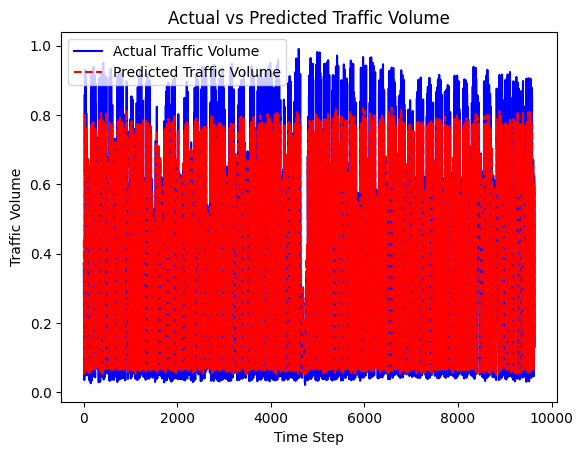

Text(0, 0.5, 'Residuals')

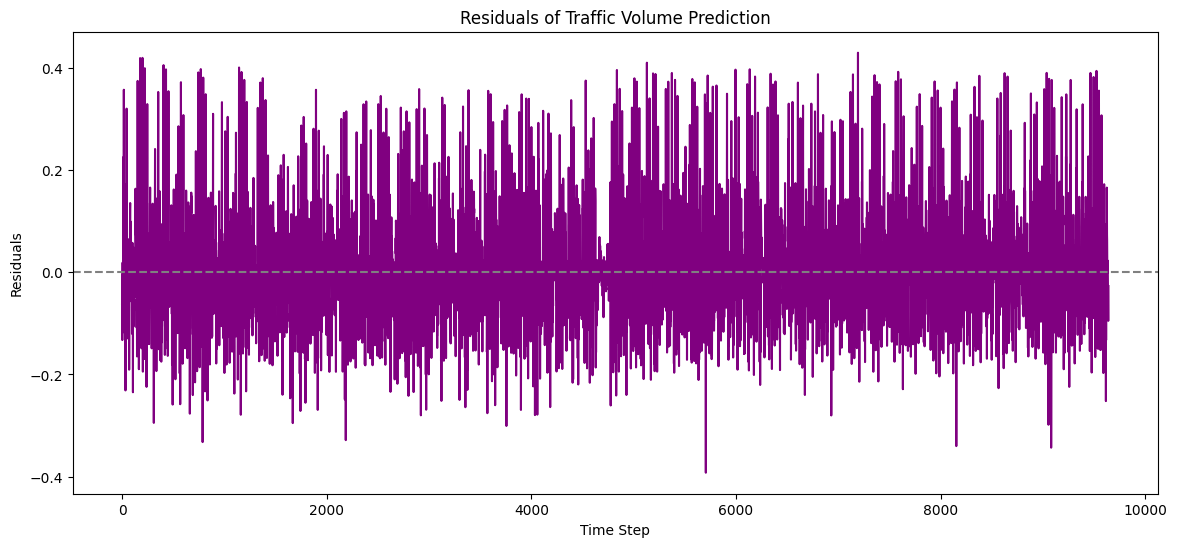

In [ ]:
# Plotting actual vs. predicted values
plt.plot(y_test, label='Actual Traffic Volume', color='blue')
plt.plot(y_pred, label='Predicted Traffic Volume', color='red', linestyle='dashed')
plt.title("Actual vs Predicted Traffic Volume")
plt.xlabel("Time Step")
plt.ylabel("Traffic Volume")
plt.legend()
plt.show()

# Plot residuals (errors) if desired
plt.figure(figsize=(14, 6))
plt.plot(y_test - y_pred.flatten(), label='Residuals (Actual - Predicted)', color='purple')
plt.axhline(0, color='gray', linestyle='--')
plt.title("Residuals of Traffic Volume Prediction")
plt.xlabel("Time Step")
plt.ylabel("Residuals")

#<p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 1px; color:#207d06; font-size:100%; text-align:left;padding: 0px; border-bottom: 3px solid #207d06;">**Implementing Resnet-LSTM**</p>

In [69]:
# Define features and target
# Check the actual column names in your DataFrame
print(data.columns)

# Assuming 'date_time' is actually named 'date_time_column', adjust accordingly:
X = data.drop(columns=['traffic_volume', 'date_time'])  # Replace 'date_time_column' with the actual column name
y = data['traffic_volume']

# Split data into train and test sets (80% train, 20% test)
split_index = int(len(data) * 0.8)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

Index(['holiday', 'temp', 'rain_1h', 'snow_1h', 'clouds_all', 'weather_main',
       'weather_description', 'date_time', 'traffic_volume',
       'traffic_volume_lag_1', 'traffic_volume_lag_2', 'traffic_volume_lag_3',
       'traffic_volume_lag_6', 'traffic_volume_lag_12',
       'traffic_volume_lag_24'],
      dtype='object')


In [70]:
def create_resnet(input_shape):
    input_layer = Input(shape=input_shape)
    x = Conv1D(64, kernel_size=3, activation='relu', padding='same')(input_layer)
    x = MaxPooling1D(pool_size=2)(x)

    # Residual block 1 (both Conv1D layers use 64 filters)
    y = Conv1D(64, kernel_size=3, activation='relu', padding='same')(x)
    y = Conv1D(64, kernel_size=3, activation='relu', padding='same')(y)
    x = Add()([x, y])
    x = MaxPooling1D(pool_size=2)(x)

    # Residual block 2 (both Conv1D layers use 128 filters)
    y = Conv1D(128, kernel_size=3, activation='relu', padding='same')(x)
    y = Conv1D(128, kernel_size=3, activation='relu', padding='same')(y)
    x = Conv1D(128, kernel_size=1, padding='same')(x)  # Match dimensions
    x = Add()([x, y])

    x = Flatten()(x)
    output_layer = Dense(64, activation='relu')(x)
    return Model(input_layer, output_layer)

# Reshape data for ResNet
X_train_resnet = np.expand_dims(X_train, axis=2)
X_test_resnet = np.expand_dims(X_test, axis=2)

# Create and compile ResNet model
resnet_model = create_resnet(input_shape=(X_train_resnet.shape[1], 1))
resnet_model.compile(optimizer='adam', loss='mse')

In [93]:
# Train ResNet model
resnet_model.fit(X_train_resnet, y_train, epochs=25, batch_size=128, validation_split=0.2)

# Extract features
X_train_features = resnet_model.predict(X_train_resnet)
X_test_features = resnet_model.predict(X_test_resnet)


Epoch 1/25
241/241 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.0034 - val_loss: 0.0033
Epoch 2/25
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0035 - val_loss: 0.0033
Epoch 3/25
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0033 - val_loss: 0.0034
Epoch 4/25
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0034 - val_loss: 0.0033
Epoch 5/25
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0034 - val_loss: 0.0033
Epoch 6/25
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0032 - val_loss: 0.0035
Epoch 7/25
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0032 - val_loss: 0.0033
Epoch 8/25
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0036 - val_loss: 0.0033
Epoch 9/25
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0033 - val_loss: 0.0036
Epoch 10/25
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0034 - val_loss: 0.0034
Epoch 11/25
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0033 - val_loss: 0.0035
Epoch 12/25
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/ste

In [94]:
# Reshape for LSTM input
X_train_lstm = np.reshape(X_train_features, (X_train_features.shape[0], 1, X_train_features.shape[1]))
X_test_lstm = np.reshape(X_test_features, (X_test_features.shape[0], 1, X_test_features.shape[1]))

# LSTM model
lstm_model = Sequential([
    LSTM(50, activation='relu', input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])),
    Dense(1)
])
lstm_model.compile(optimizer='adam', loss='mse')

# Train LSTM model
lstm_model.fit(X_train_lstm, y_train, epochs=25, batch_size=128, validation_split=0.2)

Epoch 1/25


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


241/241 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0208 - val_loss: 0.0034
Epoch 2/25
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0031 - val_loss: 0.0034
Epoch 3/25
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0032 - val_loss: 0.0034
Epoch 4/25
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0032 - val_loss: 0.0034
Epoch 5/25
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0032 - val_loss: 0.0034
Epoch 6/25
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0032 - val_loss: 0.0034
Epoch 7/25
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0031 - val_loss: 0.0034
Epoch 8/25
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0032 - val_loss: 0.0035
Epoch 9/25
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0032 - val_loss: 0.0034
Epoch 10/25
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0033 - val_loss: 0.0034
Epoch 11/25
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0033 - val_loss: 0.0034
Epoch 12/25
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.

In [95]:
# Make predictions
y_pred = lstm_model.predict(X_test_lstm)

# Inverse scaling for accuracy calculation using the traffic_scaler
y_test_inv = traffic_scaler.inverse_transform(y_test.values.reshape(-1, 1))
y_pred_inv = traffic_scaler.inverse_transform(y_pred)

# Calculate evaluation metrics
rmse_decimal = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
mse_decimal = mean_squared_error(y_test_inv, y_pred_inv)
mae_decimal = mean_absolute_error(y_test_inv, y_pred_inv)
mape_decimal = np.mean(np.abs((y_test_inv - y_pred_inv) / y_test_inv))
r2_decimal = r2_score(y_test_inv, y_pred_inv)

# Convert MAPE and R2 to percentage
rmse_percentage = rmse_decimal * 100
mse_percentage = mse_decimal * 100
mae_percentage = mae_decimal * 100
mape_percentage = mape_decimal * 100
r2_percentage = r2_decimal * 100

# Display results
print("Metrics in Decimal Format:")
print(f"RMSE: {rmse_decimal}, MSE: {mse_decimal}, MAE: {mae_decimal}, MAPE: {mape_decimal}, R2: {r2_decimal}")

print("\nMetrics in Percentage Format:")
print(f"RMSE: {rmse_percentage}%, MSE: {mse_percentage}%, MAE: {mae_percentage}%, MAPE: {mape_percentage}%, R2: {r2_percentage}%")

302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Metrics in Decimal Format:
RMSE: 400.55593608734927, MSE: 160445.05793481265, MAE: 263.90704788455037, MAPE: 0.13323556034479084, R2: 0.9585754867699804

Metrics in Percentage Format:
RMSE: 40055.593608734926%, MSE: 16044505.793481264%, MAE: 26390.704788455037%, MAPE: 13.323556034479084%, R2: 95.85754867699804%
